# **Drowsiness Detection System**

**Importing Required Libraries**

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
tf.random.set_seed(42)
import matplotlib.pyplot as plt
from glob import glob
import cv2
import os
import shutil
import random
import math
import tensorflow_datasets as tfds

**Checking TensorFlow Version**

In [ ]:
from tensorflow.python import keras
print(keras.__version__)

2.6.0


**Creating a Folder to Store TFRecords**

In [ ]:
!mkdir images

**Function to Convert Arrays to Binary Stream**

In [ ]:
def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

**Function to Convert A Sample to Binary Stream**

In [ ]:
def serialize_example(image,label):
    feature = {
        'image':tf.train.Feature(bytes_list=tf.train.BytesList(value=[image])),
        'label':_bytes_feature(tf.io.serialize_tensor(label))
    }
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    return example.SerializeToString()


**Function to Create TF Records from Binary Stream Objects**

In [ ]:
def tf_writer(op_path,filelist):
    classes=['Closed','Open']
    with tf.io.TFRecordWriter(op_path,options=tf.io.TFRecordOptions(compression_type="GZIP")) as writer:
                random.shuffle(filelist)
                for fn in filelist:
                    label = np.array([0,0],dtype='float64')
                    img = open(fn,'rb').read()
                    lab = fn.split('/')[-2]
                    lab = classes.index(lab)
                    label[lab] = 1.0
                    tf_example = serialize_example(img,label)
                    writer.write(tf_example)

**Creating records path**

In [ ]:
def create_records(path,op):
    classes=['Closed','Open']
    files_list = glob(path+'/Closed/*')
    files_list1 = glob(path+'/Open/*')
    com_list = files_list + files_list1
    tf_writer(op,com_list)
def create_records_test_val(path):
    classes=["Closed",]
    files_list = glob(path+'/Closed/*')
    files_list1 = glob(path+'/Open/*')
    com_list = files_list + files_list1
    tf_writer("test_rec",com_list[:len(com_list)//2])
    tf_writer("val_rec",com_list[len(com_list)//2:])


**Calling all the above Functions**

In [ ]:
create_records("/kaggle/input/yawn-eye-dataset-new/dataset_new/train","train_rec")

In [ ]:
create_records_test_val('/kaggle/input/yawn-eye-dataset-new/dataset_new/test')

**Below Functions create TF Dataset from TFRecords effeciently**

In [ ]:
def parse_image(example):
    feature = {'image':tf.io.FixedLenFeature([],tf.string),
              'label':tf.io.FixedLenFeature([],tf.string)}
    features = tf.io.parse_single_example(example,feature)
    image = tf.io.decode_jpeg(features['image'],channels = 3)
    image = tf.image.resize(image,[256,256])
    label = tf.io.parse_tensor(features['label'], out_type=tf.float64)
    label = tf.reshape(label,shape=(2,))
    return image,label
def read_dataset(filename,batchs):
    data = tf.data.TFRecordDataset(filename,compression_type = "GZIP")
    ds = configure(data)
    return ds

def configure(data):
    data = data.map(parse_image,num_parallel_calls = tf.data.experimental.AUTOTUNE)
    data = data.shuffle(500)
    data = data.batch(32,drop_remainder = True)
    data = data.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
    return data

**Calling the above functions to Create a full TF dataset**

In [ ]:
def use_records():
    train = read_dataset("/kaggle/working/train_rec",32)
    val = read_dataset("/kaggle/working/val_rec",32)
    test = read_dataset("/kaggle/working/test_rec",32)
    return train,val,test
train_ds,val_ds,test_ds = use_records()

In [ ]:
train_ds,val_ds,test_ds

(<PrefetchDataset shapes: ((32, 256, 256, 3), (32, 2)), types: (tf.float32, tf.float64)>,
 <PrefetchDataset shapes: ((32, 256, 256, 3), (32, 2)), types: (tf.float32, tf.float64)>,
 <PrefetchDataset shapes: ((32, 256, 256, 3), (32, 2)), types: (tf.float32, tf.float64)>)

**Checking the shape of a batch in our TF Dataset**

In [ ]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy().shape)

Image shape:  (32, 256, 256, 3)
Label:  (32, 2)


**Visualising a Sample**

Label:  [1. 0.]


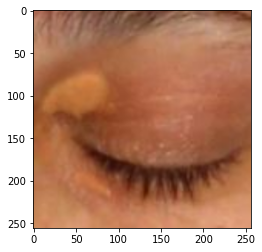

In [ ]:
#Label 1 , 0 => Closed & Label 0 , 1 => Open
for image, label in train_ds.take(1):
  print("Label: ", label.numpy()[0])
  plt.imshow(image.numpy()[0].astype("uint8"))

**Creating CallBacks to choose the choose the epoch's weight that gives the best score**

In [ ]:
cb = [tf.keras.callbacks.ModelCheckpoint("./first_model.h5",monitor='val_accuracy',save_best_only=True,mode='max')]

**Building CNN Architecture**

In [ ]:
def build():
  model = tf.keras.Sequential([
  tf.keras.layers.Resizing(256,256),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.RandomFlip(mode="horizontal"),
  tf.keras.layers.RandomRotation(0.4, fill_mode='reflect',interpolation='bilinear'),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(2,activation='softmax')
 ])
  model.compile(
  optimizer='adam',
  loss=tf.losses.CategoricalCrossentropy(),
  metrics=['accuracy'])
  return model

**Calling CNN Architecture Function**

In [ ]:
model = build()

**Training our own scratch-built CNN**

In [ ]:
deep_model = model.fit(train_ds,epochs=10,callbacks=cb,validation_data = val_ds)

**The results are below**

**Visualsing Our Model's Performance**

<AxesSubplot:>

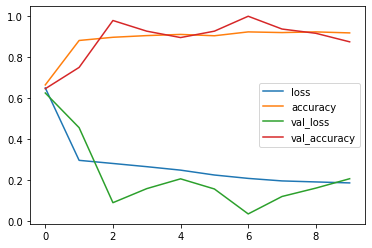

In [ ]:
pd.DataFrame(deep_model.history).plot()

**Evaluating model to Test Our Model**

In [ ]:
model.evaluate(val_ds)

3/3 [==============================] - 0s 23ms/step - loss: 0.0826 - accuracy: 0.9688


[0.08255937695503235, 0.96875]

In [ ]:
model.evaluate(test_ds)

3/3 [==============================] - 0s 22ms/step - loss: 0.1376 - accuracy: 0.9792


[0.13758485019207, 0.9791666865348816]